In [1]:
import pywt
import pywt.data
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from copy import deepcopy
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import time,math,cv2
from skimage.util import random_noise
from scipy import ndimage, misc
from skimage import measure
from pylfsr import LFSR
%matplotlib inline

In [2]:
def rhu(n, decimals=2):
    multiplier = 10 ** decimals
    return np.float32(math.floor(n*multiplier + 0.5) / multiplier)
round=np.vectorize(rhu)

In [3]:
coverimg = np.array(Image.open('cover.jpeg').convert('L').resize((512,512)))
cover_img = np.array(Image.open('cover.jpeg').convert('L').resize((512,512))).astype('single')

## Discrete Wavelet Transform

In [4]:
coeffs = pywt.dwt2(cover_img, 'haar' ,mode='periodization')
LL, (LH, HL, HH) = coeffs
print(LL.shape,LL.dtype)

(256, 256) float32


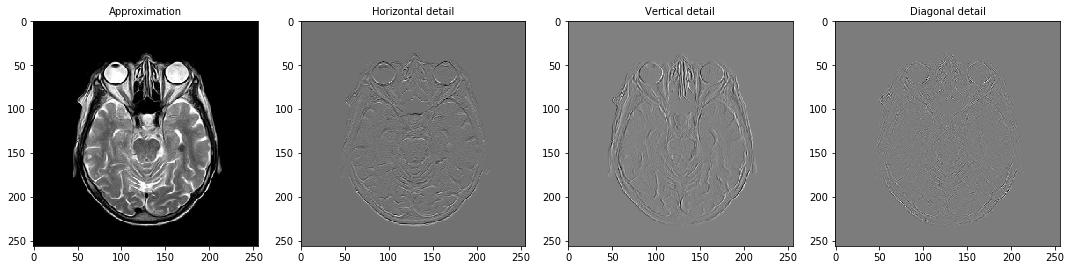

In [5]:
titles = ['Approximation', 'Horizontal detail', 'Vertical detail', 'Diagonal detail']
fig = plt.figure(figsize=(15, 15))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
fig.tight_layout()
plt.show()

## Image Watermark Scrambling and Embedding in LH sub-band

(256, 256) float32


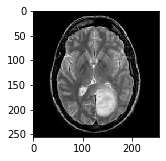

In [6]:
wimg = np.array(Image.open('brain2.jpg').convert('L').resize((256,256))).astype('single')
print(wimg.shape,wimg.dtype)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 5, 1)
ax.imshow(wimg, cmap=plt.cm.gray)
fig.tight_layout()
plt.show()

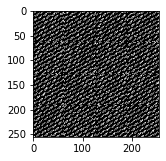

float32


In [7]:
# image Scrambling
# Arnold transform period = 48
atwimg = deepcopy(wimg)
N = 256
AT = np.zeros([N, N]).astype('single')
key, a, b = 27, 3, 5
for i in range(key):
    for y in range(N):       
        for x in range(N):                      
            xx = (x+b*y)%N          
            yy = ((a*x)+(a*b+1)*y)%N          
            AT[yy][xx] = atwimg[y][x]   
    atwimg = deepcopy(AT)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 5, 1)
ax.imshow(atwimg, cmap=plt.cm.gray)
fig.tight_layout()
plt.show()
print(atwimg.dtype)

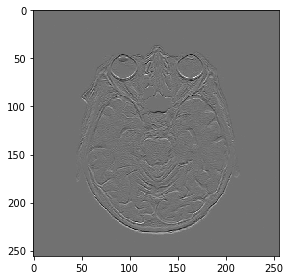

float32


In [8]:
# Adding Image Watermark
alpha = np.float32(0.005)
WLL = deepcopy(LH)
for i in range(256):
    for j in range(256):
        WLL[i][j] = WLL[i][j] + alpha*(atwimg[i][j])
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(WLL, cmap=plt.cm.gray)
fig.tight_layout()
plt.show()
print(WLL.dtype)

## Text Watermark Encryption using PN Sequence and Embedding in HL sub-band

In [9]:
# The initial state
state = [0,0,0,1,0,1,0,1,0,1,1]
# The LFSR polynomial use a primitive polynomail to get maximum period length
poly = [5, 4, 3, 2]
l = LFSR(fpoly=poly, initstate =state)

message = b"This is a Test Message for patient 1245789 details"
ciphertext = b""

# generate all LFSR sequence
allseq = l.runFullCycle()
seq = ""
seq_index = 0

# Convert LFSR bits into a string
for x in allseq:
    seq += str(x)

for counter in range(len(message)):
    ran_seq = seq[seq_index: seq_index+8]
    # Now encrypt by XOR convert to bytes and append to ciphertext
    ciphertext += bytes([int(message[counter]) ^ int(ran_seq, 2)])
    seq_index += 8  # Move sequence to Next byte

print(ciphertext)

b'\xfeS\x8d\xb1\xf4\x1e\xba\xa5\xc9\xcf\xc7n"\xab\x06[\xc6\xcd?L \x19\xb8<\xe1\x8b\x10\xc5|\x86\x08\x0fU\x90\xe2\xe5E\xfd\xb0\x9f\xd7\xaa+5\xbaRw\xca\xd2?'


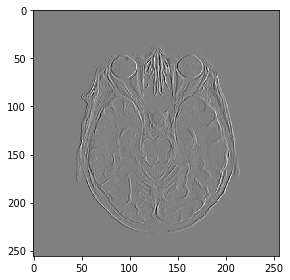

float32


In [10]:
# Adding Text Watermark
WHL = deepcopy(HL)
t=0
for i in range(256):
    for j in range(256):
        WHL[i][j] = WHL[i][j] + alpha*(ciphertext[t])
        t+=1
        if t==len(ciphertext):
            break
    if t==len(ciphertext):
            break
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(WHL, cmap=plt.cm.gray)
fig.tight_layout()
plt.show()
print(WLL.dtype)

## Watermarked Image

float32


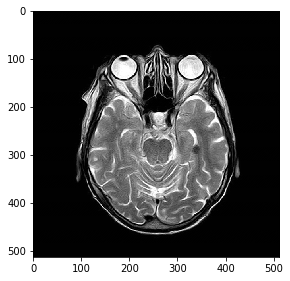

In [11]:
LH = deepcopy(WLL)
HL = deepcopy(WHL)
fimg = np.array(pywt.waverec2([LL, (LH, HL, HH)], 'haar', mode='periodization'))
print(fimg.dtype)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(fimg, cmap=plt.cm.gray)
fig.tight_layout()
plt.show()
Image.fromarray(fimg).save("watermarked.tif")

## Noise - Salt & Pepper, Gaussian, Speckle

In [12]:
# ff = np.array(Image.open('watermarked.tif'))
# #noise_img = random_noise(ff, mode='s&p', clip=False, amount=0.01).astype('single')
# #noise_img = random_noise(ff, mode='gaussian', clip=False, mean=1, var=0.5).astype('single')
# #noise_img = random_noise(ff, mode='speckle', clip=False, mean=0, var=0.01).astype('single')
# print(noise_img.dtype)
# fimg = deepcopy(round(noise_img))
# print(fimg.dtype)
# fig = plt.figure(figsize=(15, 15))
# ax = fig.add_subplot(1, 4, 1)
# ax.imshow(ff, cmap=plt.cm.gray)
# fig.tight_layout()
# plt.show()
# fig = plt.figure(figsize=(15, 15))
# ax = fig.add_subplot(1, 4, 1)
# ax.imshow(fimg, cmap=plt.cm.gray)
# fig.tight_layout()
# plt.show()
# # print(ff)
# # print(fimg)
# print((ff==fimg).all())
# k=0
# for i in range(512):
#     for j in range(512):
#         if(ff[i][j]!=fimg[i][j]):
#             k+=1
# print(k)

## JPEG Compression

In [13]:
# ff = np.array(Image.open('watermarked.tif'))
# Image.fromarray(fimg).convert('RGB').save("watermarked.jpeg",quality=10)
# Image.fromarray(fimg).convert('RGB').save("watermarked.jpeg",quality=50)
# fimg = np.array(Image.open('watermarked.jpeg').convert('L').resize((512,512))).astype('single')

## Rotation

In [14]:
# ff = np.array(Image.open('watermarked.tif'))
# fimg = ndimage.rotate(ff,1,reshape=False,order=0,mode='nearest')
# print(fimg.shape,fimg.dtype)
# fig = plt.figure(figsize=(15, 15))
# ax = fig.add_subplot(1, 4, 1)
# ax.imshow(ff, cmap=plt.cm.gray)
# fig.tight_layout()
# ax = fig.add_subplot(1, 4, 3)
# ax.imshow(fimg, cmap=plt.cm.gray)
# fig.tight_layout()
# plt.show()
# # print(ff)
# # print(fimg)
# k=0
# for i in range(512):
#     for j in range(512):
#         if(ff[i][j]!=fimg[i][j]):
# #             print(ff[i][j],fimg[i][j])
#             k+=1
# print(k)

## Results

## Performance analysis at varying gain (At character length = 22)
#### 0.001=> MSE - 0.0015, PSNR - 76.12, SSIM - 0.9999, NCC - 0.9960
#### 0.005 => MSE - 0.0396, PSNR - 62.15, SSIM - 0.9995, NCC - 0.9960
#### 0.01  => MSE - 0.1586, PSNR - 56.13, SSIM - 0.9981, NCC - 0.9961
#### 0.05  => MSE - 3.9661, PSNR - 42.15, SSIM - 0.9565, NCC - 0.9961
#### 0.1   => MSE - 15.864, PSNR - 36.13, SSIM - 0.8553, NCC - 0.9961
#### 0.5   => MSE - 396.61, PSNR - 22.15, SSIM - 0.3450, NCC - 0.9962

##  Performance analysis for various length of text watermark (At Gain Factor = 0.005)
#### 10  => MSE - 0.0396, PSNR - 62.15, SSIM - 0.9995, NCC - 0.9960
#### 22  => MSE - 0.0396, PSNR - 62.15, SSIM - 0.9995, NCC - 0.9960
#### 34  => MSE - 0.0396, PSNR - 62.14, SSIM - 0.9995, NCC - 0.9960
#### 50  => MSE - 0.0397, PSNR - 62.14, SSIM - 0.9995, NCC - 0.9960
#### 101 => MSE - 0.0398, PSNR - 62.13, SSIM - 0.9995, NCC - 0.9960

In [15]:
# alpha = 0.005 and text watermark length = 50
print("MSE ",measure.compare_mse(coverimg, fimg))
print("PSNR ",measure.compare_psnr(coverimg, fimg))
print("SSIM ",measure.compare_ssim(coverimg, fimg))

MSE  0.039842200835162954
PSNR  62.12737040549797
SSIM  0.9995342037190607


C:\Users\kalpe\Anaconda3\lib\site-packages\skimage\measure\simple_metrics.py:127: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
C:\Users\kalpe\Anaconda3\lib\site-packages\skimage\measure\_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


## AES Encryption of Watermarked Image

In [16]:
s=time.time()
print("Block Size in bytes ",AES.block_size)
raw=fimg.tobytes()
key = get_random_bytes(16)
print("AES Key ",key)
ctr_cipher = AES.new(key, AES.MODE_CTR)
start=time.time()
enc_data = ctr_cipher.encrypt(raw)
print("Time taken to encrypt in seconds ",time.time()-start)
print(len(raw),len(enc_data))
enc_image=np.reshape(np.frombuffer(enc_data,dtype=np.float32),(512,512))
Image.fromarray(enc_image).save('encrypted.tif')

Block Size in bytes  16
AES Key  b'G\xed=\xeb\xc5*a\xb3q\xe2kK^\x8faw'
Time taken to encrypt in seconds  0.0
1048576 1048576


## Encrypted Image

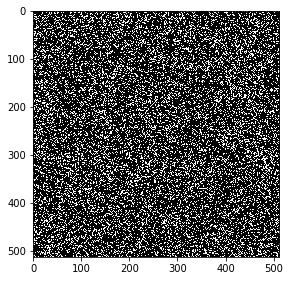

In [17]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(Image.open('encrypted.tif'), cmap=plt.cm.gray)
fig.tight_layout()
plt.show()

## NPCR

In [18]:
A=np.array(Image.open('encrypted.tif'))
B=np.array(Image.open('watermarked.tif'))
s=0
for i in range(512):
    for j in range(512):
        if A[i][j]!=B[i][j]:
            s+=1
print(s*100/(512*512))

100.0


## UACI

In [19]:
A=np.array(Image.open('encrypted.tif').convert('L'))
B=np.array(Image.open('watermarked.tif').convert('L'))
s=0
abc=0
for i in range(512):
    for j in range(512):
        s+=abs(A[i][j]-B[i][j])
        abc=max(abc,abs(A[i][j]-B[i][j]))
t=512*512*255
res=s/t
print(res*100)

C:\Users\kalpe\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in ubyte_scalars
  import sys
C:\Users\kalpe\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in ubyte_scalars
  


36.415605732038905


## AES Decryption

True
Time taken to decrypt in seconds  0.0


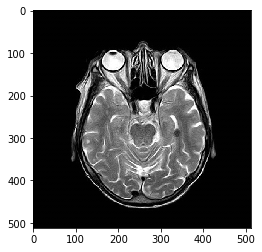

In [20]:
to_decrypt_img=np.array(Image.open('encrypted.tif'))
enc_raw=to_decrypt_img.tobytes()
print(enc_data==enc_raw)

ctr_decipher = AES.new(key, AES.MODE_CTR, nonce=ctr_cipher.nonce)
start1=time.time()
plain_data = ctr_decipher.decrypt(enc_raw)
print("Time taken to decrypt in seconds ",time.time()-start1)
dec_image=np.reshape(np.frombuffer(plain_data,dtype=np.float32),(512,512))
imgplot = plt.imshow(dec_image,cmap=plt.cm.gray)
plt.show()
# dec_image==noise_img

In [21]:
coeffs = pywt.dwt2(cover_img, 'haar' ,mode='periodization')
LL, (LH, HL, HH) = coeffs
coeffs = pywt.dwt2(dec_image, 'haar' ,mode='periodization')
iLL, (iLH, iHL, iHH) = coeffs
LL.dtype,iLL.dtype

(dtype('float32'), dtype('float32'))

## Extraction of Image and Text Watermark from LH and HL sub-bands

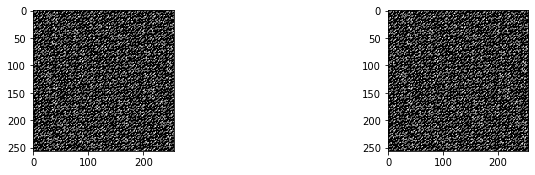

13


In [22]:
FWLL = np.zeros([256,256]).astype('single')
for i in range(256):
    for j in range(256):
        FWLL[i][j] = max(np.float32(0.0),min(np.float32(255),(iLH[i][j]-LH[i][j])/alpha))
FWLL=round(FWLL)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(FWLL, cmap=plt.cm.gray)
ax = fig.add_subplot(1, 4, 3)
ax.imshow(atwimg, cmap=plt.cm.gray)
fig.tight_layout()
plt.show()
k=0
for i in range(256):
    for j in range(256):
        if(FWLL[i][j]!=atwimg[i][j]):
#             print(FWLL[i][j],atwimg[i][j])
            k+=1
print(k)

In [23]:
FWHL = deepcopy(iHL)
t=0
r_ciphertext=b""
for i in range(256):
    for j in range(256):
        r_ciphertext+=bytes([int(min(255,round(abs(iHL[i][j]-HL[i][j])/alpha)))])
        t+=1
        if t==len(ciphertext):
            break
    if t==len(ciphertext):
            break
        
print(r_ciphertext)
print(ciphertext)
bin1=bin(int.from_bytes(r_ciphertext, byteorder="big")).strip('0b')
bin2=bin(int.from_bytes(ciphertext, byteorder="big")).strip('0b')
lenn=min(len(bin1),len(bin2))
k=0
for i in range(lenn):
    if(bin1[i]!=bin2[i]):
        k+=1
print(k,lenn)
print("BER:",k*100/lenn)

b'\xfeS\x8d\xb1\xf4\x1e\xba\xa5\xc9\xcf\xc7n"\xab\x06[\xc6\xcd?L \x19\xb8<\xe1\x8b\x10\xc5|\x86\x08\x0fU\x90\xe2\xe5E\xfd\xb0\x9f\xd7\xaa+5\xbaRw\xca\xd2?'
b'\xfeS\x8d\xb1\xf4\x1e\xba\xa5\xc9\xcf\xc7n"\xab\x06[\xc6\xcd?L \x19\xb8<\xe1\x8b\x10\xc5|\x86\x08\x0fU\x90\xe2\xe5E\xfd\xb0\x9f\xd7\xaa+5\xbaRw\xca\xd2?'
0 400
BER: 0.0


## Decryption of Image and Text Watermark

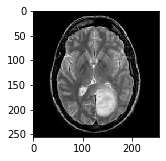

In [24]:
attwimg = deepcopy(FWLL)
N = 256
AT = np.zeros([N, N]).astype('single')
key, a, b = 27, 3, 5 
for i in range(key):  
    for y in range(N):       
        for x in range(N):                     
            xx = ((a*b+1)*x-b*y)%N
            yy = (-a*x+y)%N
            AT[yy][xx] = attwimg[y][x]  
    attwimg = deepcopy(AT)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 5, 1)
ax.imshow(attwimg, cmap=plt.cm.gray)
fig.tight_layout()
plt.show()

In [25]:
plaintext = b""
# Reset The LFSR sequence to start from beginning
seq_index = 0
for counter in range(len(r_ciphertext)):
    ran_seq = seq[seq_index: seq_index+8]
    plaintext += bytes([int(r_ciphertext[counter]) ^ int(ran_seq, 2)])
    seq_index += 8

print(plaintext)

b'This is a Test Message for patient 1245789 details'


In [26]:
# Calculate NCC
iwimg = wimg.astype('single')
n = 256
ncc=np.zeros([n]).astype('single')
for i in range(n):
    corr = (iwimg[i].dot(attwimg[i]))/(np.sqrt(iwimg[i].dot(iwimg[i])*attwimg[i].dot(attwimg[i])))
    if np.isnan(corr):
        corr = 0
    ncc[i] = corr
print(np.mean(ncc))

0.99609375


C:\Users\kalpe\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in float_scalars
  


# Performance Against Different Attacks

## 1) Salt & Pepper Noise at different density
#### Density : 0.0001 => NC - 0.9955, BER - 0.0
#### Density : 0.001 => NC - 0.9791, BER - 0.0
#### Density : 0.01 => NC - 0.8863, BER - 0.0

## 2) Gaussian Noise at different mean and variance
#### Mean : 0, Variance : 0.0005 => NC - 0.9574, BER - 0
#### Mean : 0, Variance : 0.005 => NC - 0.9406, BER - 0
#### Mean : 0, Variance : 0.05 => NC - 0.9031, BER - 0.25
#### Mean : 0, Variance : 0.5 => NC - 0.7353, BER - 0.50
#### Mean : 1, Variance : 0.0005 => NC - 0.9559, BER - 0
#### Mean : 1, Variance : 0.005 => NC - 0.9409, BER - 0
#### Mean : 1, Variance : 0.05 => NC - 0.9008, BER - 0.25
#### Mean : 1, Variance : 0.5 => NC - 0.7395, BER - 0.50

## 3) Speckle Noise at different mean and variance
#### Mean : 0, Variance : 0.0001 => NC - 0.9361, BER - 0
#### Mean : 0, Variance : 0.001 => NC - 0.8887, BER - 0
#### Mean : 0, Variance : 0.01 => NC - 0.7626, BER - 0.25
#### Mean : 0, Variance : 0.0025 => NC - 0.8465, BER - 0.25
#### Mean : 0, Variance : 0.025 => NC - 0.7043, BER - 0.50
#### Mean : 0, Variance : 0.25 => NC - 0.6337, BER - 1.00

## 4) JPEG Compression at different Quality Factors
#### QF : 10 => NC - 0.8957, BER - 0.25
#### QF : 50 => NC - 0.9246, BER - 0

## 5) Rotation at 1 degree
#### NC - 0.7361, BER - 2.25